<center><h1>TDA OpenEdition Journals </h1> </center>

# 1. Data

In [2]:
import pandas as pd

In [3]:
#Number of sessions = 170_705
df = pd.read_csv("sessions_170705.csv")

In [4]:
#The name of journals present in the plateform
import json

with open("journal_names") as f:

    data = json.load(f)

journal_names = [journal["pub_name"] for journal in data["response"]["docs"]]

In [5]:
#Extract the name of the journal from the request
df['journal'] = df["request"].str.split('/').str[3]

In [6]:
#Remove what is not a journal name anything that contains the HTTP string
def replace(name, set_names=journal_names):

    if "HTTP" in name:

        return None
    
    else:

        if name in set_names:

            return name
        
        else:

            return None
    

df["journal"] = df["journal"].apply(replace)

In [7]:
def group_sessions(df):
    """
    Groups sessions in the DataFrame and creates a list of sequences of the 'journal' column for each session.

    Parameters:
    - df (DataFrame): Input DataFrame containing 'session_id', 'time_local', and 'journal' columns.

    Returns:
    - dict: A dictionary where keys are session IDs and values are lists of sequences of the 'journal' column for each session.
    """
    session_sequences = {}

    # Sort DataFrame by 'time_local'
    df_sorted = df.sort_values(by='time_local')

    # Group sorted DataFrame by 'session_id' and aggregate 'journal' column into a list
    grouped = df_sorted.groupby('session_id')['journal'].apply(list)

    # Convert the grouped result into a dictionary
    session_sequences = grouped.to_dict()

    return session_sequences

In [8]:
session_sequences = group_sessions(df)

In [9]:
#The corpus is a list of sequences in each session
corpus = [sequence for _, sequence in session_sequences.items()]

In [10]:
#Jump over the NA
def remove_na(sequence):

    return [element for element in sequence if element != None]

corpus = [remove_na(sequence) for sequence in corpus]

In [11]:
#Keep only the sequences with at least 2 elements
corpus = [sequence for sequence in corpus if len(sequence)>=2 and len(sequence)<=50]

# 2. Pipeline

In [12]:
from gensim.models import Word2Vec

In [13]:
model_sg = Word2Vec(corpus, vector_size=50, window=5, min_count=1, workers=4, sg=1)

In [14]:
#Skip-gram representations
vocab_sg = list(model_sg.wv.key_to_index)
X_sg = model_sg.wv[vocab_sg]

In [15]:
from sklearn.manifold import TSNE

# Perform dimensionality reduction using t-SNE for skip gram
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne_sg = tsne.fit_transform(X_sg)

In [16]:
#Cluster for better visualization
from sklearn.cluster import DBSCAN

dbscan  = DBSCAN(eps=7, min_samples=10)

journals_labels = dbscan.fit_predict(X_tsne_sg)

In [235]:
import plotly.graph_objects as go
import plotly.express as px
from tqdm.auto import tqdm
import numpy as np

colors = px.colors.qualitative.Plotly

color_dict = {label:colors[i] for i, label in enumerate(np.unique(journals_labels))}

# Create a scatter plot
fig = go.Figure()

# Add scatter trace
fig.add_trace(go.Scatter(
    x=X_tsne_sg[:, 0],
    y=X_tsne_sg[:, 1],
    mode='markers',
    marker=dict(
        size=8,
        opacity=0.7
    ),
    marker_color= list(map(color_dict.get, journals_labels)),
    text=vocab_sg  # Display the label on hover
))

# Add annotations for each point
for i, label in enumerate(tqdm(vocab_sg)):
    fig.add_annotation(
        x=X_tsne_sg[i, 0],
        y=X_tsne_sg[i, 1],
        text=label,
        showarrow=False,
        xshift=0,
        yshift=5,
        font=dict(
            size=10,
            color='black'  # Adjust font color as needed
        )
    )

# Update layout
fig.update_layout(
    title="2D representation of topics using t-sne (Skip-gram)",
    xaxis_title="Dimension 1",
    yaxis_title="Dimension 2",
    width=1_800,
    height=1_000,
    hovermode='closest'
)

# Show plot
fig.write_html("tsne_journals.html")

  0%|          | 0/592 [00:00<?, ?it/s]

In [17]:
themes_vectors_sg_tsne = {theme: X_tsne_sg[i] for i, theme in enumerate(vocab_sg)}

In [21]:
def themes_to_vectors(theme_names_list, theme_representation_dict):
    """
    Convert a list of lists of theme names into a list of lists of vectors using a theme representation dictionary.

    Parameters:
        theme_names_list (list): List of lists where each inner list contains theme names.
        theme_representation_dict (dict): Dictionary mapping theme names to their vector representations.

    Returns:
        list: List of lists where each inner list contains vectors corresponding to the theme names.
    """
    vectors_list = []

    for inner_list in theme_names_list:
        vectorized_inner_list = np.array([theme_representation_dict[theme] for theme in inner_list])
        vectors_list.append(vectorized_inner_list)

    return vectors_list

In [22]:
points_clouds_sg_tsne = themes_to_vectors(corpus, themes_vectors_sg_tsne)

In [23]:
from gtda.homology import VietorisRipsPersistence

homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

diagrams_sg_tsne= persistence.fit_transform(points_clouds_sg_tsne)

In [24]:
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
patterns_sg_tsne = persistence_entropy.fit_transform(diagrams_sg_tsne)

In [25]:
patterns_sample = patterns_sg_tsne[np.random.randint(0, patterns_sg_tsne.shape[0], 20_000)]

In [26]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [27]:
#use the Mini Batch Kmeans and find the best cluster based on the silhouette score

def mini_batch_clustering(data, k_limit=10, batch_size=100, random_state=None):

    best_k = 2  # Minimum value for k
    inertia_scores = []
    silhouette_scores = []

    for k in tqdm(range(2, k_limit + 1)):
        # Mini Batch K-Means clustering
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=random_state)
        labels = kmeans.fit_predict(data)

        # Inertia (within-cluster sum of squared distances)
        inertia_scores.append(kmeans.inertia_)

        # Silhouette Score
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)

        # Update best k based on silhouette score
        if silhouette_avg > silhouette_scores[best_k - 2]:  # -2 because range starts from 2
            best_k = k

    return best_k, inertia_scores, silhouette_scores

In [31]:
best_k, inertia_scores1, silhouette_scores1 = mini_batch_clustering(patterns_sample, batch_size=5_000)

  0%|          | 0/9 [00:00<?, ?it/s]

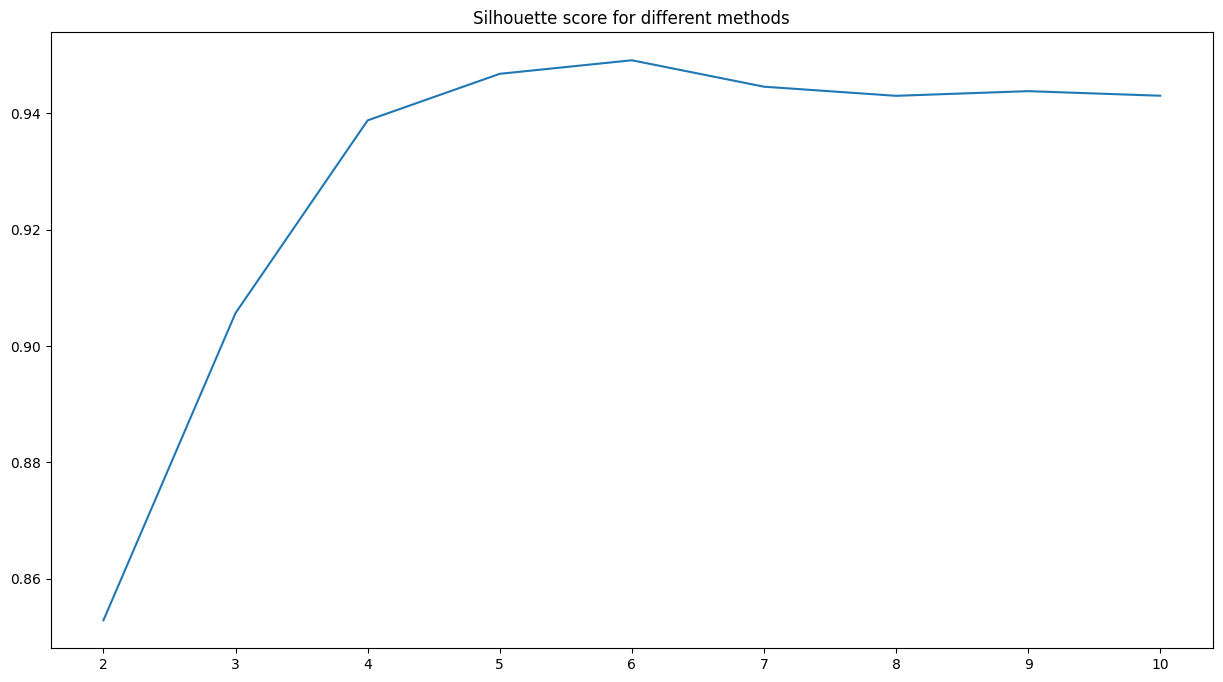

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

plt.title("Silhouette score for different methods")

plt.plot(np.arange(2, 11), silhouette_scores1, label="skip-gram tsne")

plt.show()

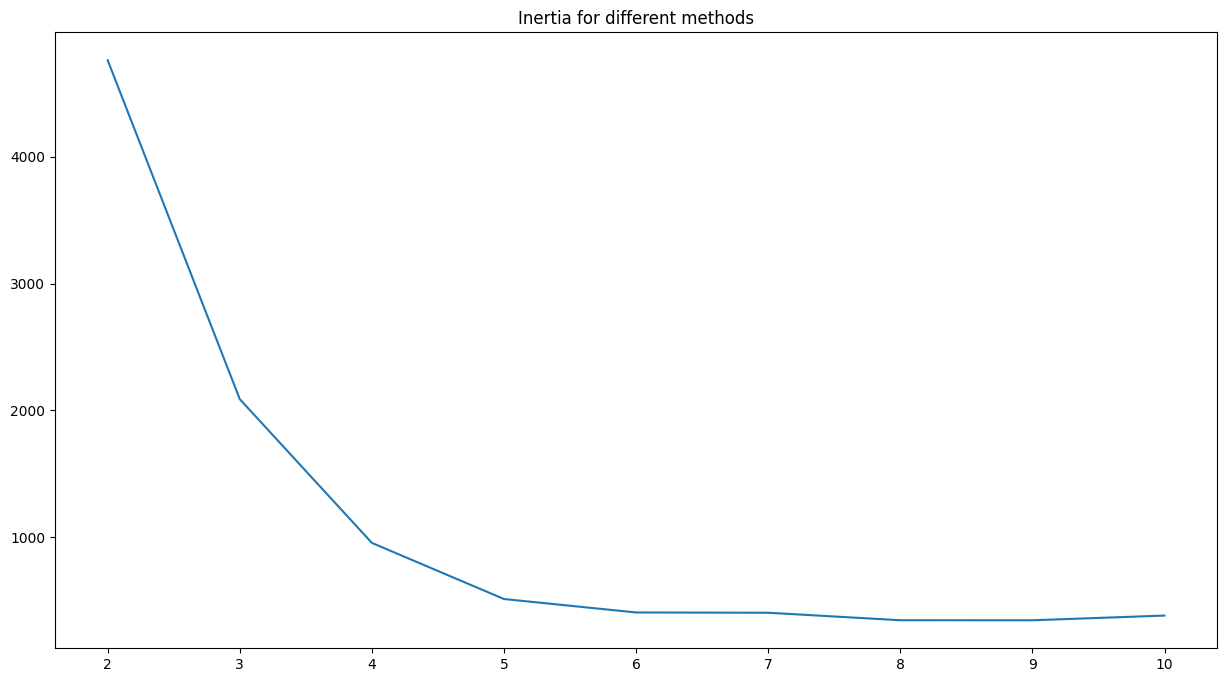

In [33]:
plt.figure(figsize=(15, 8))

plt.title("Inertia for different methods")

plt.plot(np.arange(2, 11), inertia_scores1, label='skip-gram tsne')

plt.show()

In [34]:
kmeans = MiniBatchKMeans(n_clusters=4, batch_size=10_000)

labels1 = kmeans.fit_predict(patterns_sg_tsne)

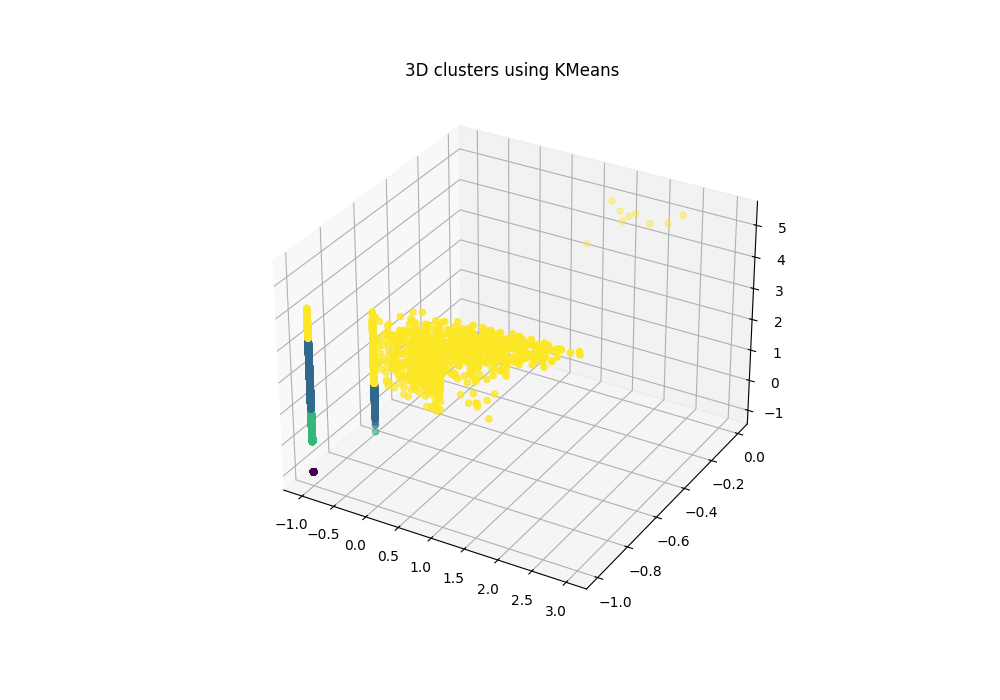

In [35]:
%matplotlib widget

# Import libraries
from mpl_toolkits import mplot3d


# Creating dataset
z = patterns_sg_tsne[:,0]
x = patterns_sg_tsne[:,1]
y = patterns_sg_tsne[:,2]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(x, y, z, c=labels1)
plt.title("3D clusters using KMeans")

# show plot
plt.show()


In [36]:
patterns_sample = patterns_sg_tsne[np.random.randint(0, patterns_sg_tsne.shape[0], 20_000)]

#Not memory efficient :/
from  sklearn.cluster import DBSCAN

dbscan = DBSCAN()

labels2 = dbscan.fit_predict(patterns_sample)

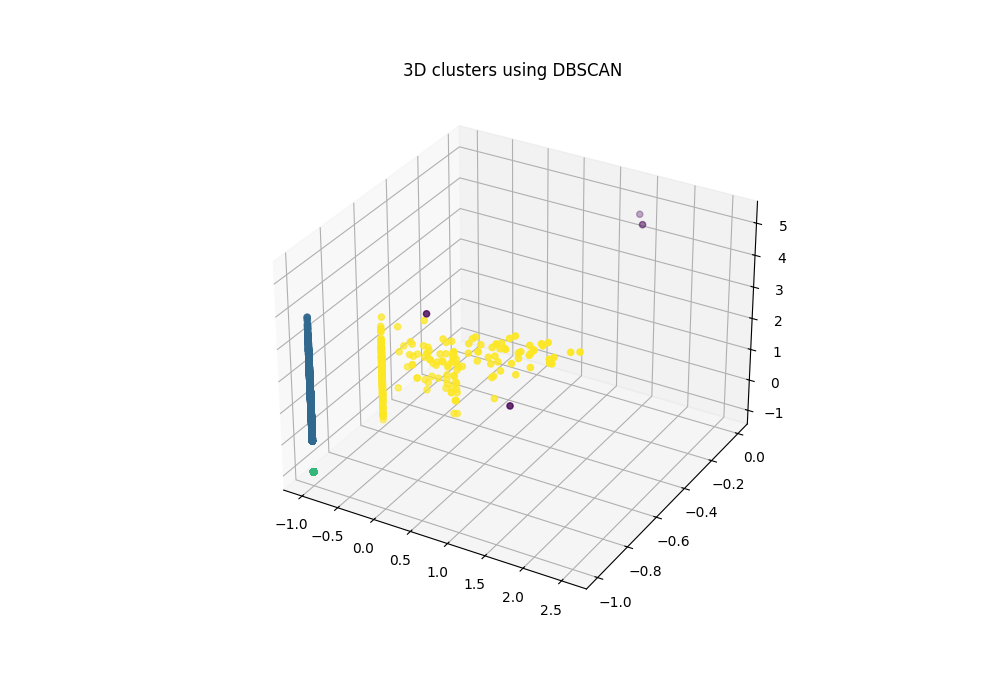

In [37]:
%matplotlib widget

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

z = patterns_sample[:,0]
x = patterns_sample[:,1]
y = patterns_sample[:,2]

# Creating plot
ax.scatter3D(x, y, z, c=labels2)
plt.title("3D clusters using DBSCAN")

# show plot
plt.show()